In [1]:
from google.colab import drive
import pathlib 
drive.mount('/content/drive', force_remount=True)
%cd "/content/drive/My Drive/ADA/Project/"

Mounted at /content/drive
/content/drive/My Drive/ADA/Project


In [4]:
import re
import numpy as np
import pandas as pd

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy

from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
from gensim import corpora


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
# WARNING : If the data has already been processed, skip this cell

# import the data 
path = pathlib.Path('Bastien.ipynb').parent.resolve()
path_to_quotes = str(path) + '/data/Tesla-quotes-2015.json' 
quotes_Tesla_2015 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2016.json' 
quotes_Tesla_2016 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2017.json' 
quotes_Tesla_2017 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2018.json' 
quotes_Tesla_2018 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2019.json' 
quotes_Tesla_2019 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2020.json' 
quotes_Tesla_2020 = pd.read_json(path_or_buf = path_to_quotes) 


################################################################################
path_to_quotes = str(path) + '/data/Chevy-quotes-2015.json' 
quotes_Chevy_2015 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2016.json' 
quotes_Chevy_2016 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2017.json' 
quotes_Chevy_2017 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2018.json' 
quotes_Chevy_2018 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2019.json' 
quotes_Chevy_2019 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2020.json' 
quotes_Chevy_2020 = pd.read_json(path_or_buf = path_to_quotes) 

#################################################################################
path_to_quotes = str(path) + '/data/Toyota-quotes-2015.json' 
quotes_Toyota_2015 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Toyota-quotes-2016.json' 
quotes_Toyota_2016 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Toyota-quotes-2017.json' 
quotes_Toyota_2017 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Toyota-quotes-2018.json' 
quotes_Toyota_2018 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Toyota-quotes-2019.json' 
quotes_Toyota_2019 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Toyota-quotes-2020.json' 
quotes_Toyota_2020 = pd.read_json(path_or_buf = path_to_quotes) 

In [78]:
def clean(text):
  ''' Removes all special characters, punctuation and spaces from string'''
    text = re.sub('[^A-Za-z]+', ' ', text)
    return text

def listToString(s): 
  ''' Transforms a list of words to a string '''
    str1 = " " 
    return (str1.join(s))

def processing(reviews):
  ''' Tokenises and removes stopwords from texts'''
  tokenized = []
  stop_rmvd_string = []

  for sentence in reviews:
    tokens = [token.text for token in nlp(sentence)]
    tokenized.append(tokens)
    contractions =     ['s',' ve ', 've','ll', ' ll ',' t ','Chevrolet', 'Tesla', 'model', 'Model', 't', 'like', 'car', 'Toyota']
    # Tesla deleted : 'like', 'model'
    # Chevrolet deleted : 'car', 'race' 
    # Toyota deleted : 'race' 
 
    stop_words = [token.text for token in nlp(sentence) if not token.is_stop ]
    stop_words = [word for word in stop_words if word not in contractions]

    stop_rmvd_string.append(listToString(stop_words))

  return tokenized, stop_rmvd_string

def reduce_quotes(vectorizer, dataframe) :
  ''' Uses TF-IDF matrix to remove quotes which seem too similar'''
  dataframe = dataframe.drop_duplicates(subset = ['quotation'])
  tfid = vectorizer.fit_transform(dataframe["quotation"])
  pairwise_similarity = (tfid * tfid.T).toarray()
  
  duplicates_id = []
  index = dataframe.index

  i = 0
  for quote in pairwise_similarity:
      for val in range(i, len(quote)):
          if (quote[val] > 0.7) and (i != val):

              duplicates_id.append(index[val])
      i += 1

  duplicates_id = list(set(duplicates_id))
  duplicates_id.sort()
  dataframe = dataframe.drop(duplicates_id, axis = 0)
  return dataframe

nlp = spacy.load('en')


def clean_df (dataframe, vectorizer,filename):
  ''' Reduces the quote sample, tokenizes and removes stopwords'''
  dataframe['Cleaned Reviews'] = dataframe['quotation'].apply(clean)
  tokenized, rmvd_string = processing(dataframe["Cleaned Reviews"])
  dataframe['Tokenized'] = tokenized
  dataframe['Stop Words Removed'] = rmvd_string 
  dataframe = reduce_quotes(vectorizer, dataframe)
  filename = 'data/'+ filename
  dataframe.to_json(path_or_buf=filename) #if you want a compression, you can add the type directly in the filename among these : {‘infer’, ‘gzip’, ‘bz2’, ‘zip’, ‘xz’, None}
  return dataframe

def LDA(dataframe, number_topics) :
  ''' Performs LDA on a preprocessed dataset. The stopwords must have been removed and duplicates discarded'''
  # greatly inspired by https://www.pluralsight.com/guides/topic-identification-nlp
  Lda_object = gensim.models.ldamulticore.LdaModel

  dataframe['Year'] = dataframe['date'].dt.year
  years = dataframe.Year.unique()
  ldas = np.empty((len(years), 12), dtype=list) # number of year x number of months in a year

  for i in range(len(years)) :
    y = years[i]
    quotes = dataframe.loc[dataframe.Year == y]
    for m in range(1,13) :
      quotes_month = quotes.loc[quotes['date'].dt.month == m]
      final_doc = [quote.split() for quote in quotes_month['Stop Words Removed']]
      if final_doc ==[] :
        continue
      dictionary = corpora.Dictionary(final_doc)
      DT_matrix = [dictionary.doc2bow(doc) for doc in final_doc]
      lda_model = Lda_object(DT_matrix, num_topics=number_topics, id2word = dictionary)
      ldas[i,m-1] = lda_model.print_topics(num_topics=2, num_words=6)
    
  return ldas

In [79]:
# WARNING : If the data has already been processed, skip this cell

vectorizer = TfidfVectorizer() # choice of TF IDF  vectorizer
print('clean Chevy dataframes')
quotes_Chevy_2015 = clean_df(quotes_Chevy_2015,vectorizer,'Chevy-quotes-2015.json')
quotes_Chevy_2016 = clean_df(quotes_Chevy_2016,vectorizer,'Chevy-quotes-2016.json')
quotes_Chevy_2017 = clean_df(quotes_Chevy_2017,vectorizer,'Chevy-quotes-2017.json')
quotes_Chevy_2018 = clean_df(quotes_Chevy_2018,vectorizer,'Chevy-quotes-2018.json')
quotes_Chevy_2019 = clean_df(quotes_Chevy_2019,vectorizer,'Chevy-quotes-2019.json')
quotes_Chevy_2020 = clean_df(quotes_Chevy_2020,vectorizer,'Chevy-quotes-2020.json')

print('clean Tesla dataframes')
quotes_Tesla_2015 = clean_df(quotes_Tesla_2015,vectorizer,'Tesla-quotes-2015.json')
quotes_Tesla_2016 = clean_df(quotes_Tesla_2016,vectorizer,'Tesla-quotes-2016.json')
quotes_Tesla_2017 = clean_df(quotes_Tesla_2017,vectorizer,'Tesla-quotes-2017.json')
quotes_Tesla_2018 = clean_df(quotes_Tesla_2018,vectorizer,'Tesla-quotes-2018.json')
quotes_Tesla_2019 = clean_df(quotes_Tesla_2019,vectorizer,'Tesla-quotes-2019.json')
quotes_Tesla_2020 = clean_df(quotes_Tesla_2020,vectorizer,'Tesla-quotes-2020.json')


print('clean Toyota dataframes')
quotes_Toyota_2015 = clean_df(quotes_Toyota_2015,vectorizer,'Toyota-quotes-2015.json')
quotes_Toyota_2016 = clean_df(quotes_Toyota_2016,vectorizer,'Toyota-quotes-2016.json')
quotes_Toyota_2017 = clean_df(quotes_Toyota_2017,vectorizer,'Toyota-quotes-2017.json')
quotes_Toyota_2018 = clean_df(quotes_Toyota_2018,vectorizer,'Toyota-quotes-2018.json')
quotes_Toyota_2019 = clean_df(quotes_Toyota_2019,vectorizer,'Toyota-quotes-2019.json')
quotes_Toyota_2020 = clean_df(quotes_Toyota_2020,vectorizer,'Toyota-quotes-2020.json')



clean Chevy dataframes
clean Tesla dataframes
clean Toyota dataframes


In [80]:
# # If the cleaning phase has already been done, this cell allows to fetch the data and skip the previous cells 
path = pathlib.Path('Bastien.ipynb').parent.resolve()
path_to_quotes = str(path) + '/data/Tesla-quotes-2015.json' 
quotes_Tesla_2015 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2016.json' 
quotes_Tesla_2016 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2017.json' 
quotes_Tesla_2017 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2018.json' 
quotes_Tesla_2018 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2019.json' 
quotes_Tesla_2019 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Tesla-quotes-2020.json' 
quotes_Tesla_2020 = pd.read_json(path_or_buf = path_to_quotes) 


################################################################################
path_to_quotes = str(path) + '/data/Chevy-quotes-2015.json' 
quotes_Chevy_2015 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2016.json' 
quotes_Chevy_2016 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2017.json' 
quotes_Chevy_2017 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2018.json' 
quotes_Chevy_2018 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2019.json' 
quotes_Chevy_2019 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Chevy-quotes-2020.json' 
quotes_Chevy_2020 = pd.read_json(path_or_buf = path_to_quotes) 

#################################################################################
path_to_quotes = str(path) + '/data/Toyota-quotes-2015.json' 
quotes_Toyota_2015 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Toyota-quotes-2016.json' 
quotes_Toyota_2016 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Toyota-quotes-2017.json' 
quotes_Toyota_2017 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Toyota-quotes-2018.json' 
quotes_Toyota_2018 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Toyota-quotes-2019.json' 
quotes_Toyota_2019 = pd.read_json(path_or_buf = path_to_quotes) 

path_to_quotes = str(path) + '/data/Toyota-quotes-2020.json' 
quotes_Toyota_2020 = pd.read_json(path_or_buf = path_to_quotes) 

In [83]:
df_chevy = quotes_Chevy_2015
df_chevy = df_chevy.append(quotes_Chevy_2015)
df_chevy = df_chevy.append(quotes_Chevy_2016)
df_chevy = df_chevy.append(quotes_Chevy_2017)
df_chevy = df_chevy.append(quotes_Chevy_2018)
df_chevy = df_chevy.append(quotes_Chevy_2019)
df_chevy = df_chevy.append(quotes_Chevy_2020)
df_chevy.reset_index(inplace=True)

df_tesla = quotes_Tesla_2015
df_tesla = df_tesla.append(quotes_Tesla_2015)
df_tesla = df_tesla.append(quotes_Tesla_2016)
df_tesla = df_tesla.append(quotes_Tesla_2017)
df_tesla = df_tesla.append(quotes_Tesla_2018)
df_tesla = df_tesla.append(quotes_Tesla_2019)
df_tesla = df_tesla.append(quotes_Tesla_2020)
df_tesla.reset_index(inplace=True)

df_toyota = quotes_Toyota_2015
df_toyota = df_toyota.append(quotes_Toyota_2015)
df_toyota = df_toyota.append(quotes_Toyota_2016)
df_toyota = df_toyota.append(quotes_Toyota_2017)
df_toyota = df_toyota.append(quotes_Toyota_2018)
df_toyota = df_toyota.append(quotes_Toyota_2019)
df_toyota = df_toyota.append(quotes_Toyota_2020)
df_toyota.reset_index(inplace=True)

In [84]:
import gensim 
from PIL import Image
import matplotlib.pyplot as plt

       index  ...                                 Stop Words Removed
0          0  ...  policy concentrate category stations developed...
1          1  ...  Sergey wrote original founders letter years ag...
2          2  ...              Elon Musk Apple hired engineers fired
3          3  ...  folds tomorrow people Connecticut disappointed...
4          4  ...   best racing planet opinion Late Stock Car racing
...      ...  ...                                                ...
16657    932  ...                          dominance technology real
16658    933  ...          settlement technically agreement Michigan
16659    935  ...  Gigafactory Berlin Brandenburg phase presence ...
16660    938  ...  state California requires lemon vehicle meet c...
16661    940  ...  space S inside far storage size constraint twi...

[16662 rows x 8 columns]


In [85]:
topics_chevy = LDA(df_chevy, number_topics = 1)
print(topics_chevy)

[[list([(0, '0.011*"going" + 0.011*"great" + 0.010*"Camaro" + 0.009*"m" + 0.009*"NHRA" + 0.009*"team"')])
  list([(0, '0.013*"great" + 0.012*"race" + 0.010*"team" + 0.009*"m" + 0.008*"good" + 0.007*"going"')])
  list([(0, '0.015*"race" + 0.015*"good" + 0.011*"weekend" + 0.009*"day" + 0.009*"today" + 0.009*"track"')])
  list([(0, '0.012*"good" + 0.011*"race" + 0.010*"track" + 0.009*"great" + 0.008*"m" + 0.007*"team"')])
  list([(0, '0.017*"race" + 0.008*"m" + 0.007*"team" + 0.007*"tomorrow" + 0.007*"lot" + 0.007*"good"')])
  list([(0, '0.014*"race" + 0.011*"good" + 0.008*"track" + 0.008*"time" + 0.008*"lot" + 0.008*"end"')])
  list([(0, '0.010*"track" + 0.009*"race" + 0.008*"good" + 0.008*"run" + 0.007*"weekend" + 0.006*"great"')])
  list([(0, '0.012*"race" + 0.010*"good" + 0.009*"weekend" + 0.009*"going" + 0.008*"team" + 0.007*"lot"')])
  list([(0, '0.013*"race" + 0.010*"team" + 0.008*"good" + 0.008*"m" + 0.008*"lot" + 0.007*"weekend"')])
  list([(0, '0.011*"race" + 0.009*"m" + 0.008*"

In [86]:
topics_tesla = LDA(df_tesla, number_topics = 1)
print(topics_tesla)

[[list([(0, '0.007*"going" + 0.006*"S" + 0.005*"year" + 0.005*"people" + 0.005*"Nightlife" + 0.005*"Northern"')])
  list([(0, '0.011*"Apple" + 0.005*"cars" + 0.004*"going" + 0.004*"S" + 0.004*"great" + 0.004*"want"')])
  list([(0, '0.010*"S" + 0.007*"cars" + 0.006*"year" + 0.006*"new" + 0.005*"going" + 0.005*"electric"')])
  list([(0, '0.006*"years" + 0.006*"new" + 0.006*"think" + 0.005*"S" + 0.005*"people" + 0.004*"need"')])
  list([(0, '0.006*"battery" + 0.005*"year" + 0.005*"people" + 0.005*"S" + 0.005*"system" + 0.005*"way"')])
  list([(0, '0.007*"X" + 0.005*"think" + 0.005*"right" + 0.005*"work" + 0.004*"year" + 0.004*"guy"')])
  list([(0, '0.006*"business" + 0.005*"new" + 0.004*"don" + 0.004*"year" + 0.003*"good" + 0.003*"developed"')])
  list([(0, '0.005*"production" + 0.005*"X" + 0.005*"S" + 0.004*"new" + 0.004*"think" + 0.004*"going"')])
  list([(0, '0.006*"X" + 0.005*"new" + 0.005*"S" + 0.004*"want" + 0.004*"going" + 0.004*"people"')])
  list([(0, '0.005*"S" + 0.004*"people" 

In [87]:
topics_toyota = LDA(df_toyota, number_topics = 1)
print(topics_toyota)

[[list([(0, '0.005*"year" + 0.005*"m" + 0.004*"good" + 0.004*"companies" + 0.004*"new" + 0.004*"industry"')])
  list([(0, '0.007*"great" + 0.007*"going" + 0.006*"Camry" + 0.006*"think" + 0.006*"time" + 0.005*"season"')])
  list([(0, '0.007*"team" + 0.006*"cars" + 0.006*"good" + 0.006*"year" + 0.004*"Camry" + 0.004*"race"')])
  list([(0, '0.006*"April" + 0.006*"race" + 0.006*"Patricia" + 0.005*"AFF" + 0.005*"great" + 0.005*"team"')])
  list([(0, '0.009*"race" + 0.008*"good" + 0.007*"track" + 0.007*"m" + 0.006*"year" + 0.006*"way"')])
  list([(0, '0.010*"new" + 0.006*"team" + 0.006*"good" + 0.006*"vehicles" + 0.006*"m" + 0.005*"customers"')])
  list([(0, '0.012*"race" + 0.009*"m" + 0.007*"good" + 0.006*"team" + 0.006*"going" + 0.005*"win"')])
  list([(0, '0.008*"great" + 0.006*"Racing" + 0.006*"team" + 0.006*"good" + 0.006*"guys" + 0.005*"race"')])
  list([(0, '0.006*"lot" + 0.005*"good" + 0.005*"team" + 0.005*"new" + 0.005*"year" + 0.005*"support"')])
  list([(0, '0.006*"going" + 0.005*

Now we want to isolate the keywords and build a cloud of words representation.

In [88]:
!pip install pygrok
import re 
from pygrok import Grok
import wordcloud as wc


def find_topics (LDA_model_result,number_topics) :
  topics = []
  for  i in range(6):
    for j in range(12):
      for k in range(number_topics):
        line = LDA_model_result[i,j]
        if str(type(line)) == "<class 'NoneType'>":
          continue
        else :
          topics.append(line[k])

  for i,topic in enumerate(topics):
    topic = re.sub(r'\d+','',topic[1])
    topic = re.sub(r'[^\w]', ' ', topic)
    topic = topic.split()
    topics[i] = topic
  return topics


def topic2wordcloud (topics,filepath,filename) :
  for i in range(len(topics)) :
    topics[i] = " ".join(word for word in topics[i])

  text = " ".join(quote for quote in topics)
  cloud = wc.WordCloud(background_color="white", max_words=200, width=800, height=800, random_state=1).generate(text)
  # to recolour the image
  fig = plt.figure(figsize = (10,10))
  plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
  plt.imshow(cloud)
  plt.savefig(filepath + '/' + filename)


def topics_date(prev_months,past_month,selected_date,topics):
  date_pattern = '%{YEAR:year}-%{MONTHNUM:month}-%{MONTHDAY:day}'
  grok = Grok(date_pattern)
  dictionnary = grok.match(selected_date)
  year = int(dictionnary.year)
  index_year = year - 2015
  month = int(dictionnary.month)
  index = index_year*12 + month
  return topics[ index - prev_months], topics[index], topics[index+past_month]

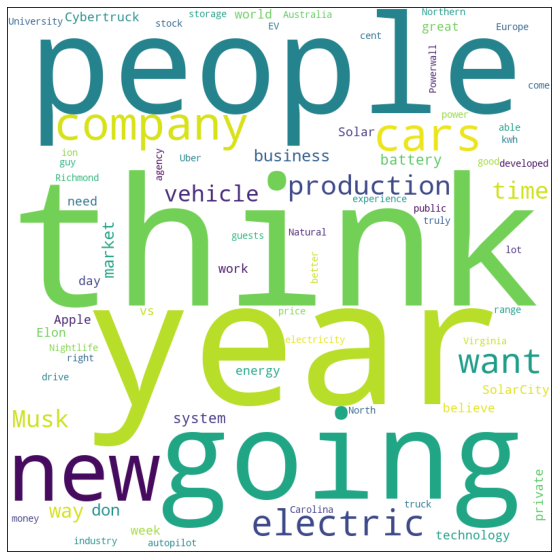

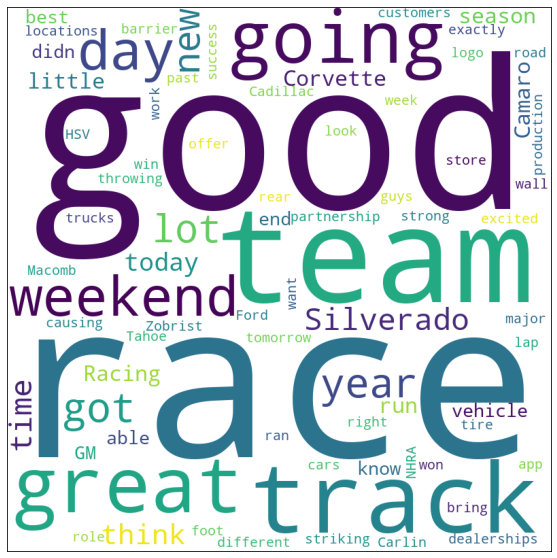

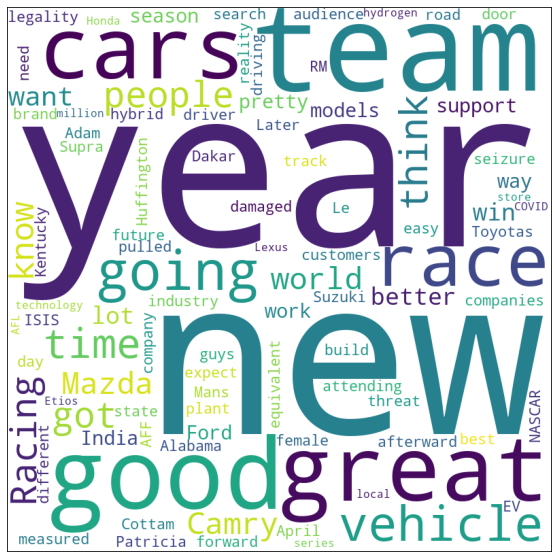

In [89]:
topics_Tesla = find_topics(topics_tesla,1)
topic2wordcloud(topics_Tesla,str(path),'tesla_cloud.png')
topics_Chevy = find_topics(topics_chevy,1)
topic2wordcloud(topics_Chevy,str(path),'chevy_cloud.png')
topics_To = find_topics(topics_toyota,1)
topic2wordcloud(topics_To,str(path),'toyota_cloud.png')

The following can be used to build an occurrence matrix for a list of topics and a lexicon of words.

In [54]:
def build_matrix(words, topics) :
  matrix = np.zeros((len(words),len(topics)))
  for i in range(len(topics)):
    for j in range(len(topics[i])) :
      index = np.where(words == topics[i,j])
      matrix[index,i] = 1

  return matrix
matrix = build_matrix(np.array(words),np.array(topics_To))
import matplotlib.pyplot as plt
base = datetime.datetime.today()
dates = ['January','February','March','April','May','June','July','August','September','October','November','December','January','February','March','April','May','June','July','August','September','October','November','December','January','February','March','April','May','June','July','August','September','October','November','December','January','February','March','April','May','June','July','August','September','October','November','December','January','February','March','April','May','June','July','August','September','October','November','December','January','February','March','April','May','June','July','August','September','October','November','December']

fig, ax = plt.subplots(figsize = (100,100))
ax.imshow(matrix)
ax.set_xticklabels(dates)  # horizontal colorbar
ax.set_yticklabels(words)  # horizontal colorbar
plt.xlabel('Months')
plt.ylabel('Words')
plt.title('Use of keywords')